# Downstream usage and evaluation of MoRA embeddings 

We here evaluate MoRA embeddings on 9 downsterwam prediction tasks spanning social and economic aspects. Due to privacy concerns, we use the distilled embeddings for demonstration.

## Load downstream data

The downstream data is preprocessed and organized according to spatial scale. For grid-level tasks, such as population and crime case prediction, each H3 grid is assigned a corresponding label. In contrast, for county- or city-level tasks, the labels are based on the respective county code or city names. For certain tasks, not all H3 grids are assigned labels due to the scarcity of open-source data, such as MOSAIKS. In such cases, the empty grids are excluded from the dataset during downstream validation.

In [1]:
import pandas as pd 


grid_level_data = pd.read_pickle('data/grid_level_data.pkl')
county_level_data = pd.read_pickle('data/county_level_data.pkl')
# city_level_data = pd.read_pickle('data/city_level_data.pkl')

In [3]:
county_level_data.head(2)

,admincode,EDU,ELD,HOU,HSR
3,110101,12.65,18.23,26.25,22.304533
4,110102,12.76,18.17,26.37,22.071317


## Load embeddings

Load the pretrained embeddings. Follow the steps in the notebook [get_embeddings](../embeddings/get_embeddings.ipynb) to generate the embeddings first. We also provide usage for SatCLIP, GeoCLIP as comparison. All the embeddings are based on the H3 grids.

In [4]:
distilled_ebds = pd.read_pickle('../embeddings/distilled_MoRA.pkl')
distilled_ebds.head(2)

,h3,ebd
0,8640e3cefffffff,"[1.162039246448791, -3.74380023908402, 3.15808..."
1,86408859fffffff,"[-0.9566033939110591, -0.9551551677419859, 2.5..."


## Generate level-specific embeddings

Using grid-level H3 embeddings, we generate county- and city-level embeddings through average aggregation.

In [5]:
import numpy as np
mapping = pd.read_pickle('data/lv6_h3_to_cityandcountyname.pkl')
result = pd.merge(distilled_ebds, mapping, on="h3", how="inner")
county_embeddings = (
        result.groupby("admincode")["ebd"]
        .agg(lambda group: np.mean(list(group), axis=0))
        .reset_index()
    )
city_embeddings = (
        result.groupby("city_name")["ebd"]
        .agg(lambda group: np.mean(list(group), axis=0))
        .reset_index()
    )

In [6]:
county_embeddings.head(2)

,admincode,ebd
0,110101,"[0.54270869630841, -2.467107192958221, 0.90779..."
1,110102,"[0.4006230121012577, -2.0908567021166586, 0.60..."


## Train LightGBM for prediction

Match embeddings at different scales with their correspondng labels for prediction.

In [7]:
grid_df = pd.merge(distilled_ebds, grid_level_data, on='h3', how ='inner')
county_df = pd.merge(county_embeddings, county_level_data ,on='admincode', how ='inner')
# city_df = pd.merge(city_embeddings, city_level_data ,on='city_name', how ='inner')

In [8]:
county_df.head(2)

,admincode,ebd,EDU,ELD,HOU,HSR
0,110101,"[0.54270869630841, -2.467107192958221, 0.90779...",12.65,18.23,26.25,22.304533
1,110102,"[0.4006230121012577, -2.0908567021166586, 0.60...",12.76,18.17,26.37,22.071317


To address the differences in sample sizes across tasks at different scales, we utilize separate sets of LightGBM hyperparameters for training. For city-level tasks, Ridge Regression is employed.

In [9]:
from utils import lgbm_train, ridge_train


grid_level_lgbm_params = {
        'learning_rate': 0.05,
        'max_depth': 7,
        'n_estimators': 1000,
        'num_leaves':  63,
        'min_child_samples': 30
    }


county_level_lgbm_params= {
    'learning_rate': 0.05,
    'max_depth': 7,
    'n_estimators': 1000,
    'num_leaves': 31,
    'min_child_samples': 50
}


seeds = 42

grid_tasks = ['POP', 'CRI', 'NTL']
# grid_tasks = ['POP', 'CRI', 'NTL', 'COS']
county_tasks = ['EDU', 'ELD', 'HOU', 'HSR']
# city_tasks = ['ENE']


results = {}

# save the results, including test_r2, test_rmse, y, y_pred in a task-specific dict

for task in grid_tasks:
    results[task] = lgbm_train(grid_df, task, grid_level_lgbm_params, seeds)

for task in county_tasks:
    results[task] = lgbm_train(county_df, task, county_level_lgbm_params, seeds)

# for task in city_tasks:
#     results[task] = ridge_train(city_df, task, seeds)
    
    

In [10]:
# show the r2

data = [{'Task': task, 'Test R²': metrics['test_r2']} for task, metrics in results.items()]
df = pd.DataFrame(data)
print(df)

  Task   Test R²
0  POP  0.814606
1  CRI  0.708313
2  NTL  0.597496
3  EDU  0.859050
4  ELD  0.812507
5  HOU  0.691934
6  HSR  0.777108


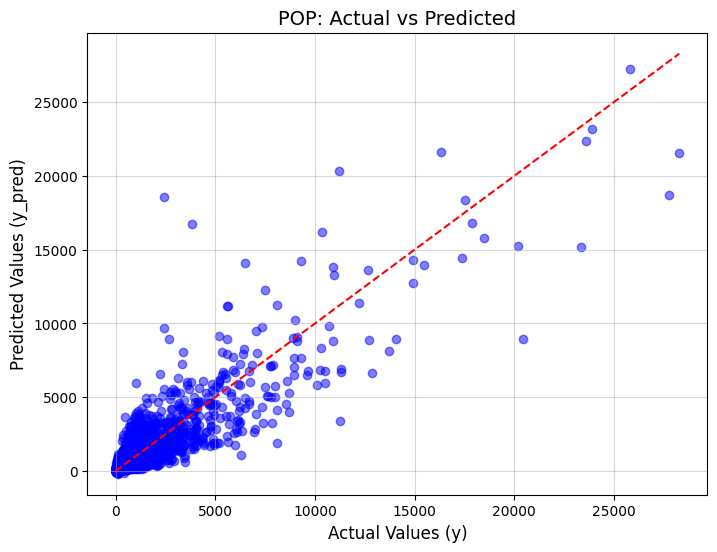

In [11]:
# plot the prediction results
import matplotlib.pyplot as plt

def plot_task_results(results, task):
    y = results[task]['y']
    y_pred = results[task]['y_pred']

    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_pred, alpha=0.5, color='blue', label=f'{task}: y vs y_pred')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal Fit')
    plt.xlabel('Actual Values (y)', fontsize=12)
    plt.ylabel('Predicted Values (y_pred)', fontsize=12)
    plt.title(f'{task}: Actual vs Predicted', fontsize=14)
    plt.grid(alpha=0.5)
    plt.show()


plot_task_results(results, 'POP')
